In [1]:
# Imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset

import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, IntegratedGradients, GradientShap, Saliency

from functools import partial

import sys
# Add the upper directory to the path
sys.path.append("../Models/")
from CustomCNNVessel import CustomResNet
from VesselsDatasetLoader import get_dataset

In [2]:
# Default device plus free memory
torch.cuda.empty_cache()
#device = "cpu"
device = torch.device("cpu")

batch_size = 8

train_loader, test_loader = get_dataset(batch_size = batch_size)

dataset_type = 'vessel'

model = CustomResNet(num_classes=2).to(device)
# Load the weights
model.load_state_dict(torch.load(f"../Models/custom_cnn_{dataset_type}.pth"))
model.eval()

CustomResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (resblock1): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resblock2): ResidualBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, trac

In [3]:
# Select a random batch from the test dataset
images, masks = next(iter(test_loader))

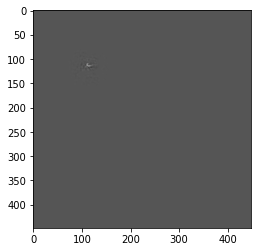

In [4]:
# Getting ONE gradient
input_image = images[2].unsqueeze(0)
input_image.requires_grad_()  # Ensure gradients are tracked for input_image

out = model(input_image)

x = 112
y = 112
score = out[0, 1, x, y]

score.backward()  # invoke backward to compute gradients

# Access the gradients from input_image, not from 'out'
gradient = input_image.grad

plt.imshow(gradient[0, 0, :, :], cmap='gray')

In [5]:
def positive_score(out, target = 1):
  search_domain = out[0, target, :, :]
  
  for i in range(200, search_domain.shape[0]):
        for j in range(200, search_domain.shape[1]):
            if search_domain[i, j] > 0:
                coordinates.append((i, j))
                return (i, j)
  return None
  
def compute_gradient_at_coordinates(model, image):
    # Ensure image requires gradient
    image = image.unsqueeze(0).requires_grad_()

    # Forward pass
    out = model(image)

    # Get the score at the specified coordinates for class 1
    x, y = positive_score(out, 1)
    score = out[0, 1, x, y]

    # Compute gradients
    score.backward()

    # Return the gradient
    return image.grad

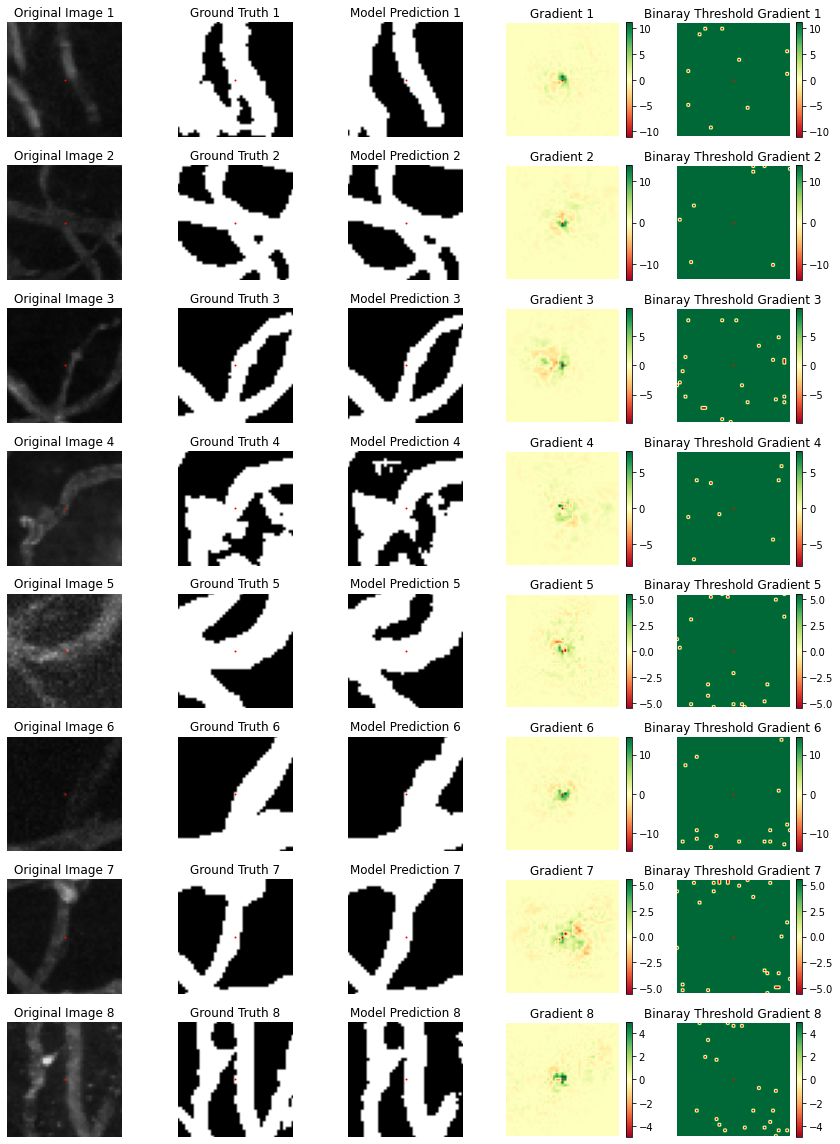

In [7]:
coordinates = []
# Iterate over all images
gradients = []
for i, img in enumerate(images):
    # Compute the gradient at the specified coordinates
    gradients.append(compute_gradient_at_coordinates(model, img))

num_images = len(gradients)

# Create a figure with 5 columns for each image: gradient, binary array, original image, and model output
fig, axes = plt.subplots(num_images, 5, figsize=(12, num_images * 2))

for i in range(num_images):
    # Gradient Visualization
    gradient = gradients[i].squeeze()
    v_max = gradient.abs().max()
    img_grad = axes[i, 3].imshow(gradient, cmap='RdYlGn', vmin=-v_max, vmax=v_max)
    axes[i, 3].set_title(f'Gradient {i+1}')
    

    # Binary Array Visualization
    binary_array = np.where(np.abs(gradient) > 1e-3, 1, 0)
    axes[i, 4].imshow(binary_array, cmap='RdYlGn')
    axes[i, 4].set_title(f'Binaray Threshold Gradient {i+1}')
    

    # Original Image Visualization
    original_img = images[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 0].imshow(original_img, cmap='gray')
    axes[i, 0].set_title(f'Original Image {i+1}')
    
    
    # Original Mask Visualization
    original_img = masks[i].detach().cpu().numpy().transpose(1, 2, 0)
    axes[i, 1].imshow(original_img, cmap='gray')
    axes[i, 1].set_title(f'Ground Truth {i+1}')
    

    # Model (Mask)Output Visualization
    output = model(images[i].unsqueeze(0))  
    out_max = torch.argmax(output, dim=1, keepdim=True)
    model_mask = out_max[0].detach().cpu().numpy()
    axes[i, 2].imshow(model_mask.transpose(1, 2, 0), cmap='gray')
    axes[i, 2].set_title(f'Model Prediction {i+1}')

    # Highlight the specified pixel and zoom in
    coord = coordinates[i]
    for ax in axes[i, :]:
        ax.scatter(coord[1], coord[0], color='red', s=1)
        ax.set_xlim((coord[1] - 20, coord[1] + 20))
        ax.set_ylim((coord[0] - 20, coord[0] + 20))
        ax.axis('off')
        
    # Add colorbars
    fig.colorbar(img_grad, ax=axes[i, 3], orientation='vertical')
    fig.colorbar(img_grad, ax=axes[i, 4], orientation='vertical')
    

plt.tight_layout()
plt.show()